In [88]:
#https://proceedings.neurips.cc/paper/2020/file/fdbe012e2e11314b96402b32c0df26b7-Paper.pdf
#http://proceedings.mlr.press/v48/wei16.pdf

import sys
sys.path.append("../../")

import tensorflow as tf
from tensorflow import keras
from pmlb import fetch_data
import numpy as np
import matplotlib.pyplot as plt
import dmp.task.aspect_test.aspect_test_utils as aspect_test_utils
from dmp.data.pmlb import pmlb_loader

_datasets = pmlb_loader.load_dataset_index()

In [118]:
def make_model(dataset, widths):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    model = keras.models.Sequential()
    model.add(tf.keras.Input(shape=inputs.shape[1:]))
    model.add(keras.layers.Dense(2, activation='relu'))
    model.add(keras.layers.Dense(2, activation='relu'))
    model.add(keras.layers.Dense(outputs.shape[1], activation=output_activation))

    model.compile(optimizer='adam',
        loss = run_loss,
        #   loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'],
        )

    print(model.summary())
    return model


def default_initializer(source_model, dest_model):
    for i, l in enumerate(source_model.layers):  # inserts old weights into new model
        old_width = l.output_shape[1]
        old_weights = l.get_weights()
        # new_weights = new_model.layers[i].get_weights()

        new_layer = dest_model.layers[i]
        new_weights = new_layer.get_weights()

        # new_weights[0] = new_weights[0] * 0
        # new_weights[1] = new_weights[1] * 0

        print(
            f'setup weights old: {old_width}, {old_weights[0].shape}, {old_weights[1].shape} new: {new_layer.output_shape[1]}, {new_weights[0].shape}, {new_weights[1].shape}')

        new_weights[0][:old_weights[0].shape[0],
                       :old_weights[0].shape[1]] = old_weights[0]
        new_weights[1][:old_weights[1].shape[0]] = old_weights[1]
        new_layer.set_weights(new_weights)


def grow_network_replace(dataset, source_model, new_widths, initializer=default_initializer):
    dataset_series, inputs, outputs, train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    dest_model = keras.Sequential()
    input_shape = source_model.input_shape

    print(f'growing {len(source_model.layers)}')

    for i, l in enumerate(source_model.layers):  # adds modified layers to new model
        old_width = l.output_shape[1]
        new_width = new_widths[i] if len(new_widths) > i else old_width
        dest_model.add(keras.layers.Dense(new_width, activation=l.activation))

    dest_model.build(input_shape)  # makes new model (and initialized weights)

    initializer(source_model, dest_model)

    dest_model.compile(optimizer='adam',
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['accuracy'])
    return dest_model


def plot_histories(configs, histories):
    for i, h in enumerate(histories):
        plt.plot(np.arange(len(h))+epochs, h)
        epochs += len(h)-1


In [119]:
# X, y = fetch_data('mnist', return_X_y=True)
# X, y = fetch_data('sleep', return_X_y=True)

def load_dataset(name):
    dataset_series, inputs, outputs =  \
                pmlb_loader.load_dataset(_datasets, name)
    run_config = aspect_test_utils.prepare_dataset(
                'shuffled_train_test_split',
                .2,
                0.0,
                {},
                dataset_series['Task'],
                inputs,
                outputs,
            )

    train_inputs = run_config['x']
    train_outputs = run_config['y']
    test_inputs = run_config['validation_data'][0]
    test_outputs = run_config['validation_data'][1]

    num_inputs = inputs.shape[1:]
    num_outputs = outputs.shape[1]
    output_activation, run_loss = \
                aspect_test_utils.compute_network_configuration(num_outputs, dataset_series)
    dataset = (dataset_series, inputs, outputs,train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss)   
    return dataset



In [120]:
def do_grow_train(configs, dataset, initializer=default_initializer):
    dataset_series, inputs, outputs,train_inputs, train_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    loss = []
    val_loss = []
    model = None
    for i, (widths, epochs) in enumerate(configs):
        if model is None:
            model = make_model(dataset, configs[0][0])
        else:
            model = grow_network_replace(
                dataset, model, widths, initializer=initializer)
        print(model.summary())
        # initial_loss = model.evaluate(train_inputs, train_outputs)[0]
        # loss.append([initial_loss])

        # initial_val_loss = model.evaluate(test_inputs, test_outputs)[0]
        # val_loss.append([initial_val_loss])

        # fit_result = model.fit(train_inputs, train_outputs, epochs = 10)
        # print(fit_result.history)
        initial_epoch = 1
        for i in range(epochs):
            end_epoch = initial_epoch + 1
            fit_result = model.fit(train_inputs, train_outputs, initial_epoch = initial_epoch, epochs = end_epoch)
            initial_epoch = end_epoch
            print(fit_result.history)
            # loss.append(model.evaluate(train_inputs, train_outputs)[0])
            loss.append(fit_result.history['loss'][0])
            val_loss.append(model.evaluate(test_inputs, test_outputs)[0])

    return model, loss, val_loss


In [122]:
dataset = load_dataset('sleep')
configs = [
    ([2, 2], 3),
    ([4, 4], 3),
    ([8, 8], 3),
    ([16, 16], 3),
]

full_configs = [([configs[-1][0], sum([c[1] for c in configs])])]

full_model, loss, val_loss = do_grow_train(full_configs, dataset, default_initializer)

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_242 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_243 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_244 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_242 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_243 (Dense)            (None, 2)                 6         
___________________________

In [123]:
full_model, model, loss, val_loss = do_grow_train(configs, dataset, default_initializer)

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_245 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_246 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_247 (Dense)            (None, 5)                 15        
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_245 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_246 (Dense)            (None, 2)                 6         
___________________________

ValueError: not enough values to unpack (expected 4, got 3)

In [58]:

plot_histories(full_configs, full_histories)
plot_histories(configs, default_histories)

plt.yscale('log')

TypeError: plot_histories() missing 1 required positional argument: 'histories'

(array([ 5., 10., 13., 10., 10.,  8., 24., 15.,  4.,  1.]),
 array([-0.70626587, -0.55378973, -0.40131354, -0.24883738, -0.09636122,
         0.05611494,  0.2085911 ,  0.36106727,  0.5135434 ,  0.66601956,
         0.81849575], dtype=float32),
 <BarContainer object of 10 artists>)

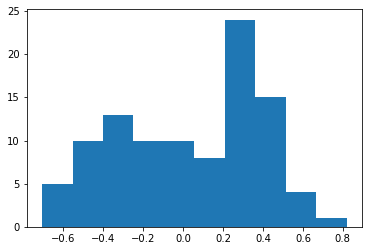

In [8]:
plt.hist(model.layers[1].get_weights()[0].reshape(-1))

In [9]:
input_dim = X.shape[1]

model = keras.models.Sequential()
model.add(tf.keras.Input(shape=(input_dim,)))
model.add(keras.layers.Dense( 10, activation='relu'))
model.add(keras.layers.Dense( 10, activation='relu'))
model.add(keras.layers.Dense( 10, activation='relu'))
model.add(keras.layers.Dense( 10, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = [model.evaluate(X,y)[0]] + model.fit(X,y,epochs=10).history['loss']

2188/2188 [==============================] - 3s 1ms/step - loss: 50.0249 - accuracy: 0.1114
Epoch 1/10
2188/2188 [==============================] - 4s 2ms/step - loss: 2.1448 - accuracy: 0.2178
Epoch 2/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.5867 - accuracy: 0.3324
Epoch 3/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.5085 - accuracy: 0.3461
Epoch 4/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.4743 - accuracy: 0.3662
Epoch 5/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.2855 - accuracy: 0.4830
Epoch 6/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.2022 - accuracy: 0.5221
Epoch 7/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.1428 - accuracy: 0.5456
Epoch 8/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.1125 - accuracy: 0.5607
Epoch 9/10
2188/2188 [==============================] - 4s 2ms/step - loss: 1.0984 - accurac

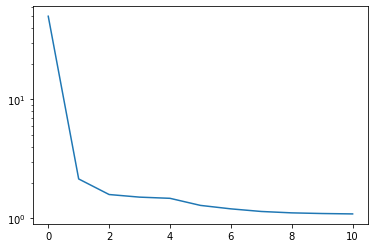

In [10]:
plt.plot(np.arange(len(history)),history)
plt.yscale('log')

(array([10.,  8.,  6., 12., 14., 12.,  8., 10., 10., 10.]),
 array([-0.5364622 , -0.4300101 , -0.32355803, -0.21710595, -0.11065388,
        -0.0042018 ,  0.10225028,  0.20870236,  0.31515443,  0.4216065 ,
         0.5280586 ], dtype=float32),
 <BarContainer object of 10 artists>)

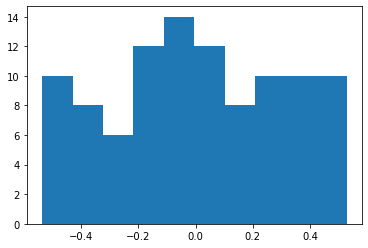

In [46]:
plt.hist(model.layers[1].get_weights()[0].reshape(-1))

In [23]:
# model.fit(X,y,epochs=5, validation_split=0.2, callbacks=keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 min_delta=0,
#                 patience=0,
#                 verbose=0,
#                 mode='auto',
#                 baseline=None,
#                 restore_best_weights=False
#             ))

(70000, 784)